<a href="https://colab.research.google.com/github/KevinTheRainmaker/MLOps/blob/main/MLOps_ExProjects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import tensorflow as tf
import tensorflow_hub as hub

In [9]:
# 'feature name': feauter dimension
ONE_HOT_FEATURES = {
    'product': 11,
    'sub_product': 45,
    'company_response': 5,
    'state': 60,
    'issue': 90,
}

# 'feature name': bucket count
BUCKET_FEATURES = {
    'zip_code': 10
}

# 'feature name': None
TEXT_FEATURES = {
    'consumer_complaint_narrative': None
}

LABEL_KEY = 'consumer_disputed'

In [10]:
def transformed_name(key):
  return key + '_xf'

In [11]:
def get_model():

  # One-hot categorical features
  input_features = []

  # write input_feature for each features
  for key, dim in ONE_HOT_FEATURES.items():
    input_features.append(
        tf.keras.Input(shape=(dim+1,),
                       name=transformed_name(key))
    )
  
  # add bucket features
  for key, dim in BUCKET_FEATURES.items():
    input_features.append(
        tf.keras.Input(shape=(dim+1,),
                       name=transformed_name(key))
    )

  # add text features
  input_texts = []
  for key in TEXT_FEATURES.keys():
    input_texts.append(
        tf.keras.Input(shape=(1,),
                       name=transformed_name(key),
                       dtype=tf.string)
    )
  
  inputs = input_features + input_texts

  # Embedding Text features
  MODULE_URL = 'https://tfhub.dev/google/universal-sentence-encoder/4'

  # Load USE's tf.hub module
  embed = hub.KerasLayer(MODULE_URL)

  # Keras' input is 2 dim but encoder's is 1 dim
  reshaped_narrative = tf.reshape(input_texts[0], [-1])
  embed_narrative = embed(reshaped_narrative)
  deep_ff = tf.keras.layers.Reshape((512,), input_shape=(1, 512))(embed_narrative)

  deep = tf.keras.layers.Dense(256, activation='relu')(deep_ff)
  deep = tf.keras.layers.Dense(64, activation='relu')(deep)
  deep = tf.keras.layers.Dense(16, activation='relu')(deep)
  
  wide_ff = tf.keras.layers.concatenate(input_features)
  wide = tf.keras.layers.Dense(16, activation='relu')(wide_ff)

  both = tf.keras.layers.concatenate([deep, wide])

  output = tf.keras.layers.Dense(1, activation='sigmoid')(both)

  # make keras model graph
  keras_model = tf.keras.models.Model(inputs, output)

  keras_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss='binary_crossentropy',
                      metrics = [
                                 tf.keras.metrics.BinaryAccuracy(),
                                 tf.keras.metrics.TruePositives()
                      ])
  
  return keras_model

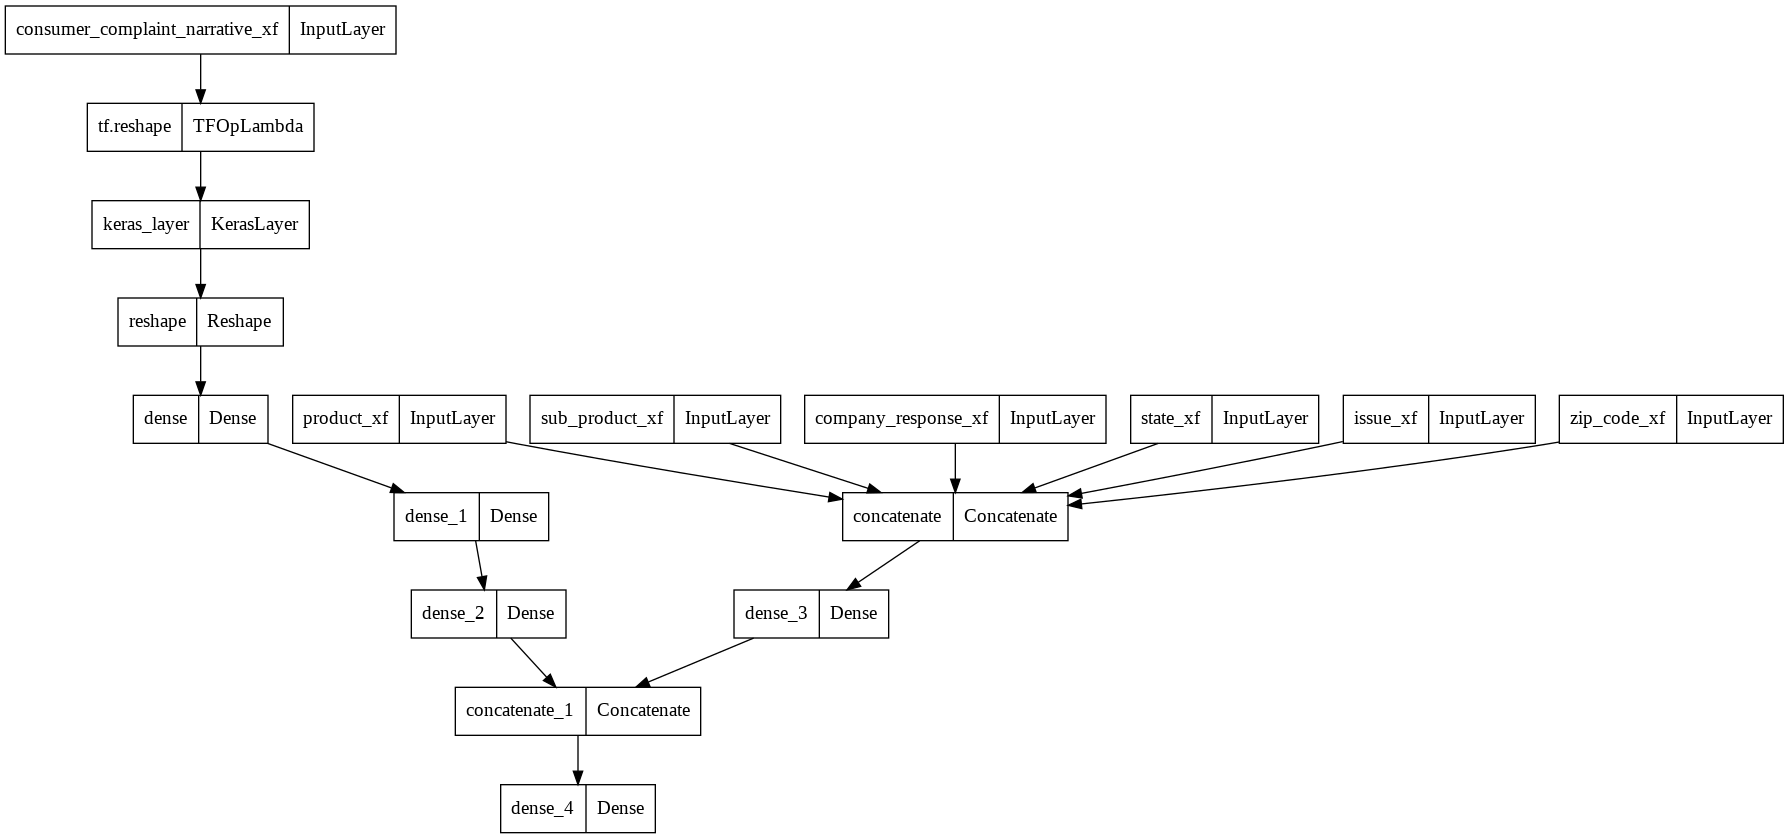

In [5]:
model = get_model()
tf.keras.utils.plot_model(model)

In [12]:
!pip install -q tensorflow_transform
import tensorflow_transform as tft

In [ ]:
def run_fn(fn_args):
  tf_transform_output = tft.TFTransformOutput(fn_args.transform_output)
  train_dataset = input_fn(fn_args.train_files, tf_transform_output)
  eval_dataset = input_fn(fn_args.eval_files, tf_transform_output)

  # load model
  model = get_model()

  # train model
  model.fit(
      train_dataset,
      steps_per_epoch=fn_args.train_steps,
      validation_data=eval_dataset,
      validation_steps=fn_args.eval_steps
  )

  # model signature
  signatures = {
      'serving_default':
      _get_serve_tf_examples_fn(
          model, 
          tf_transform_output).get_concrete_function(
              tf.TensorSpec(
                  shape=[None],
                  dtype=tf.string,
                  name='examples'
              )
          )
  }
  model.save(fn_args.serving_model_dir,
             save_format='tf', signatures=signatures)

In [13]:
# helper function
def _gzip_reader_fn(filenames):
  return tf.data.TFRecordDataset(filenames, compression_type='GZIP')

def input_fn(file_pattern, tf_transform_output, batch_size=32):
  transformed_feature_spec = (
      tf_transform_output.transformed_feature_spec().copy()
  )

  dataset = tf.data.experimental.make_batched_features_dataset(
      file_pattern=file_pattern,
      batch_size=batch_size,
      features=transformed_feature_spec,
      reader=_gzip_reader_fn,
      label_key=transformed_name(LABEL_KEY)
  )

  return dataset